In [1]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the delta_CDR for 
# the CDR potential runs (e.g., the application
# rates use the same CDR potential across the 
# board)
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "hi"
idx_1 = "001"
tag_sil_1 = "cdrpot"

# FERT LEVEL 2
fertLevel_2 = "low"
idx_2 = "001"
tag_sil_2 = "cdrpot"



In [2]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))

In [3]:
# --- add a column for CDR potential
# (see make_batch_input_*_cdrPot.py for more info on the calculation)
fs_pots = {    # [kg CO2 / kg rock]
    "gbas": 0.41,   
    "cc":   0.44,
}
# FERTLEVEL 1
dssil1 = dssil1.assign_coords(cdrpot = ("dustrate_ton_ha_yr", dssil1['dustrate_ton_ha_yr'].data*fs_pots['gbas'])).copy()
dscc1 = dscc1.assign_coords(cdrpot = ("dustrate_ton_ha_yr", dscc1['dustrate_ton_ha_yr'].data*fs_pots['cc'])).copy()
# set dustrate as a coord w/ cdrpot
dssil1 = dssil1.assign_coords(dustrate_ton_ha_yr=("cdrpot", dssil1["dustrate_ton_ha_yr"].data))
dscc1 = dscc1.assign_coords(dustrate_ton_ha_yr=("cdrpot", dscc1["dustrate_ton_ha_yr"].data))

# FERTLEVEL 2
dssil2 = dssil2.assign_coords(cdrpot = ("dustrate_ton_ha_yr", dssil2['dustrate_ton_ha_yr'].data*fs_pots['gbas'])).copy()
dscc2 = dscc2.assign_coords(cdrpot = ("dustrate_ton_ha_yr", dscc2['dustrate_ton_ha_yr'].data*fs_pots['cc'])).copy()
# set dustrate as a coord w/ cdrpot
dssil2 = dssil2.assign_coords(dustrate_ton_ha_yr=("cdrpot", dssil2["dustrate_ton_ha_yr"].data))
dscc2 = dscc2.assign_coords(dustrate_ton_ha_yr=("cdrpot", dscc2["dustrate_ton_ha_yr"].data))


### Plot 1: Contour plot of removal vs dust radius and application rate

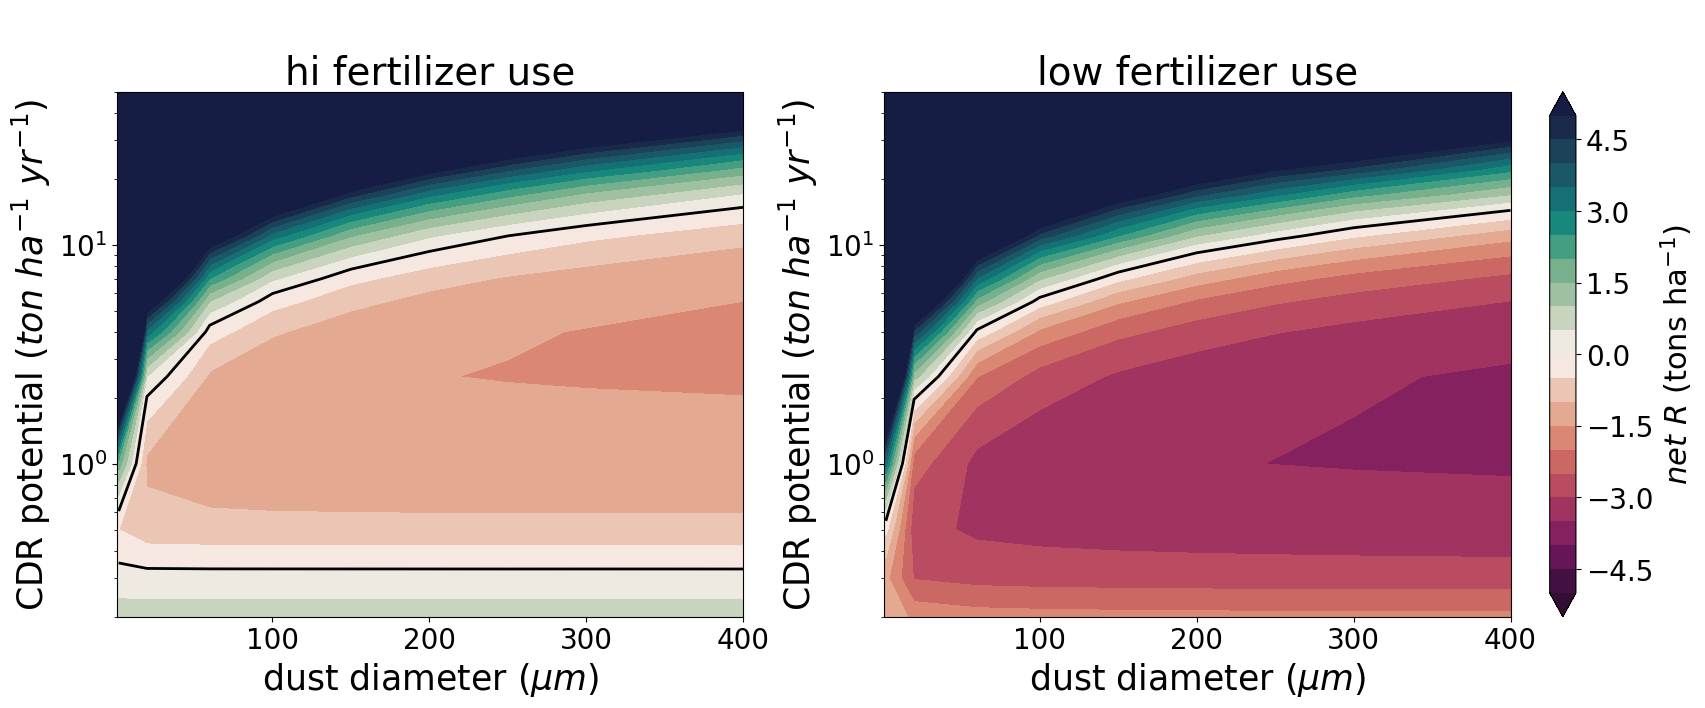

In [18]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 0
cdr_calc = 'netR_noNeg'
logX = False
logY = True

# pull out the data we want
ds1_p1 = dssil1.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_p1 = dscc1.sel(loss_percent=loss_percent, method='nearest')[cdr_var]

ds1_p2 = dssil2.sel(loss_percent=loss_percent, method='nearest')[cdr_var]
ds2_p2 = dscc2.sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_p1 = ds1_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_p1 = ds2_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

ds1_p2 = ds1_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_p2 = ds2_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = ds1_p1['dustrad'].values
y1 = np.round(ds1_p1['cdrpot'].values, 3) # round to avoid floating point errors
# [fertlevel 2]
x2 = ds1_p2['dustrad'].values
y2 = np.round(ds1_p2['cdrpot'].values, 3) # round to avoid floating point errors

# normalize color scale to center at zero
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1, (ds1_p1.transpose() - ds2_p1.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,(ds1_p1.transpose() - ds2_p1.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2, (ds1_p2.transpose() - ds2_p2.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,(ds1_p2.transpose() - ds2_p2.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$net\ R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)


### Plot 2: 
For 100 micron diameter, contour plot of CDR potential (x-axis) vs loss_percent (y-axis) for R_sil - R_cc

Probably steer clear of this if we want to introduce the R_sil-R_cc first (e.g., before loss percent, later)

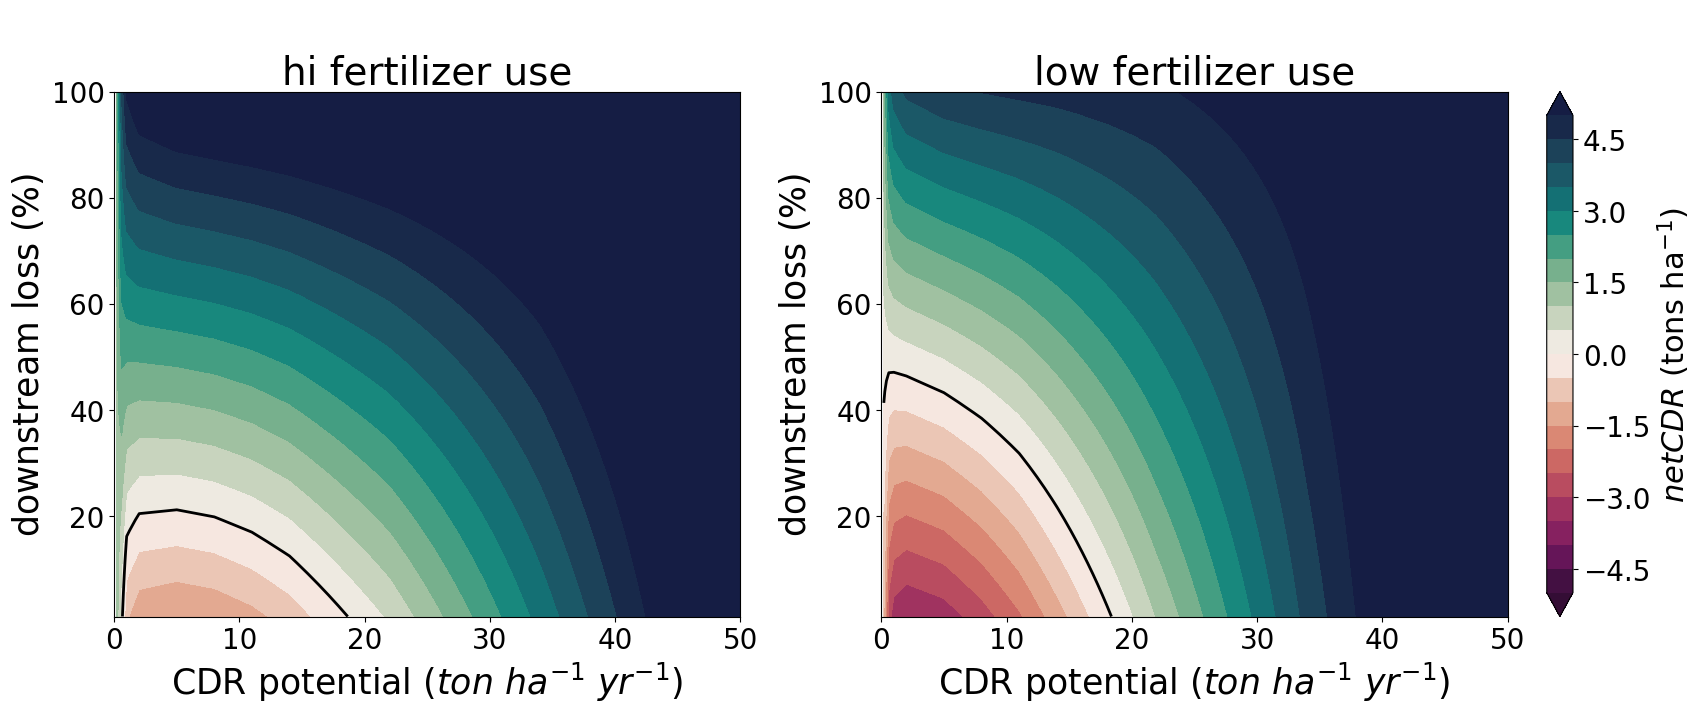

In [6]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
dustDiameter = 100. # [um]
cdr_calc = 'netR_noNeg'
logX = False
logY = False

# pull out the data we want
ds1_p1 = dssil1.sel(dustrad=dustDiameter, method='nearest')[cdr_var]
ds2_p1 = dscc1.sel(dustrad=dustDiameter, method='nearest')[cdr_var]

ds1_p2 = dssil2.sel(dustrad=dustDiameter, method='nearest')[cdr_var]
ds2_p2 = dscc2.sel(dustrad=dustDiameter, method='nearest')[cdr_var]


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
ds1_p1 = ds1_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_p1 = ds2_p1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

ds1_p2 = ds1_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
ds2_p2 = ds2_p2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (0.2 if logY else 0), 50 
ymin, ymax = (1 if logY else 1), 100 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = ds1_p1['cdrpot'].values
y1 = np.round(ds1_p1['loss_percent'].values, 3) # round to avoid floating point errors
# [fertlevel 2]
x2 = ds2_p2['cdrpot'].values
y2 = np.round(ds2_p2['loss_percent'].values, 3) # round to avoid floating point errors

# normalize color scale to center at zero
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1, (ds1_p1.transpose() - ds2_p1.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,(ds1_p1.transpose() - ds2_p1.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.ylabel(r"downstream loss $(\%)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,(ds1_p2.transpose() - ds2_p2.transpose()), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,(ds1_p2.transpose() - ds2_p2.transpose()),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.ylabel(r"downstream loss $(\%)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)


### Plot 3:
fraction of rock dissolved in the time allotted (for gbas and cc)

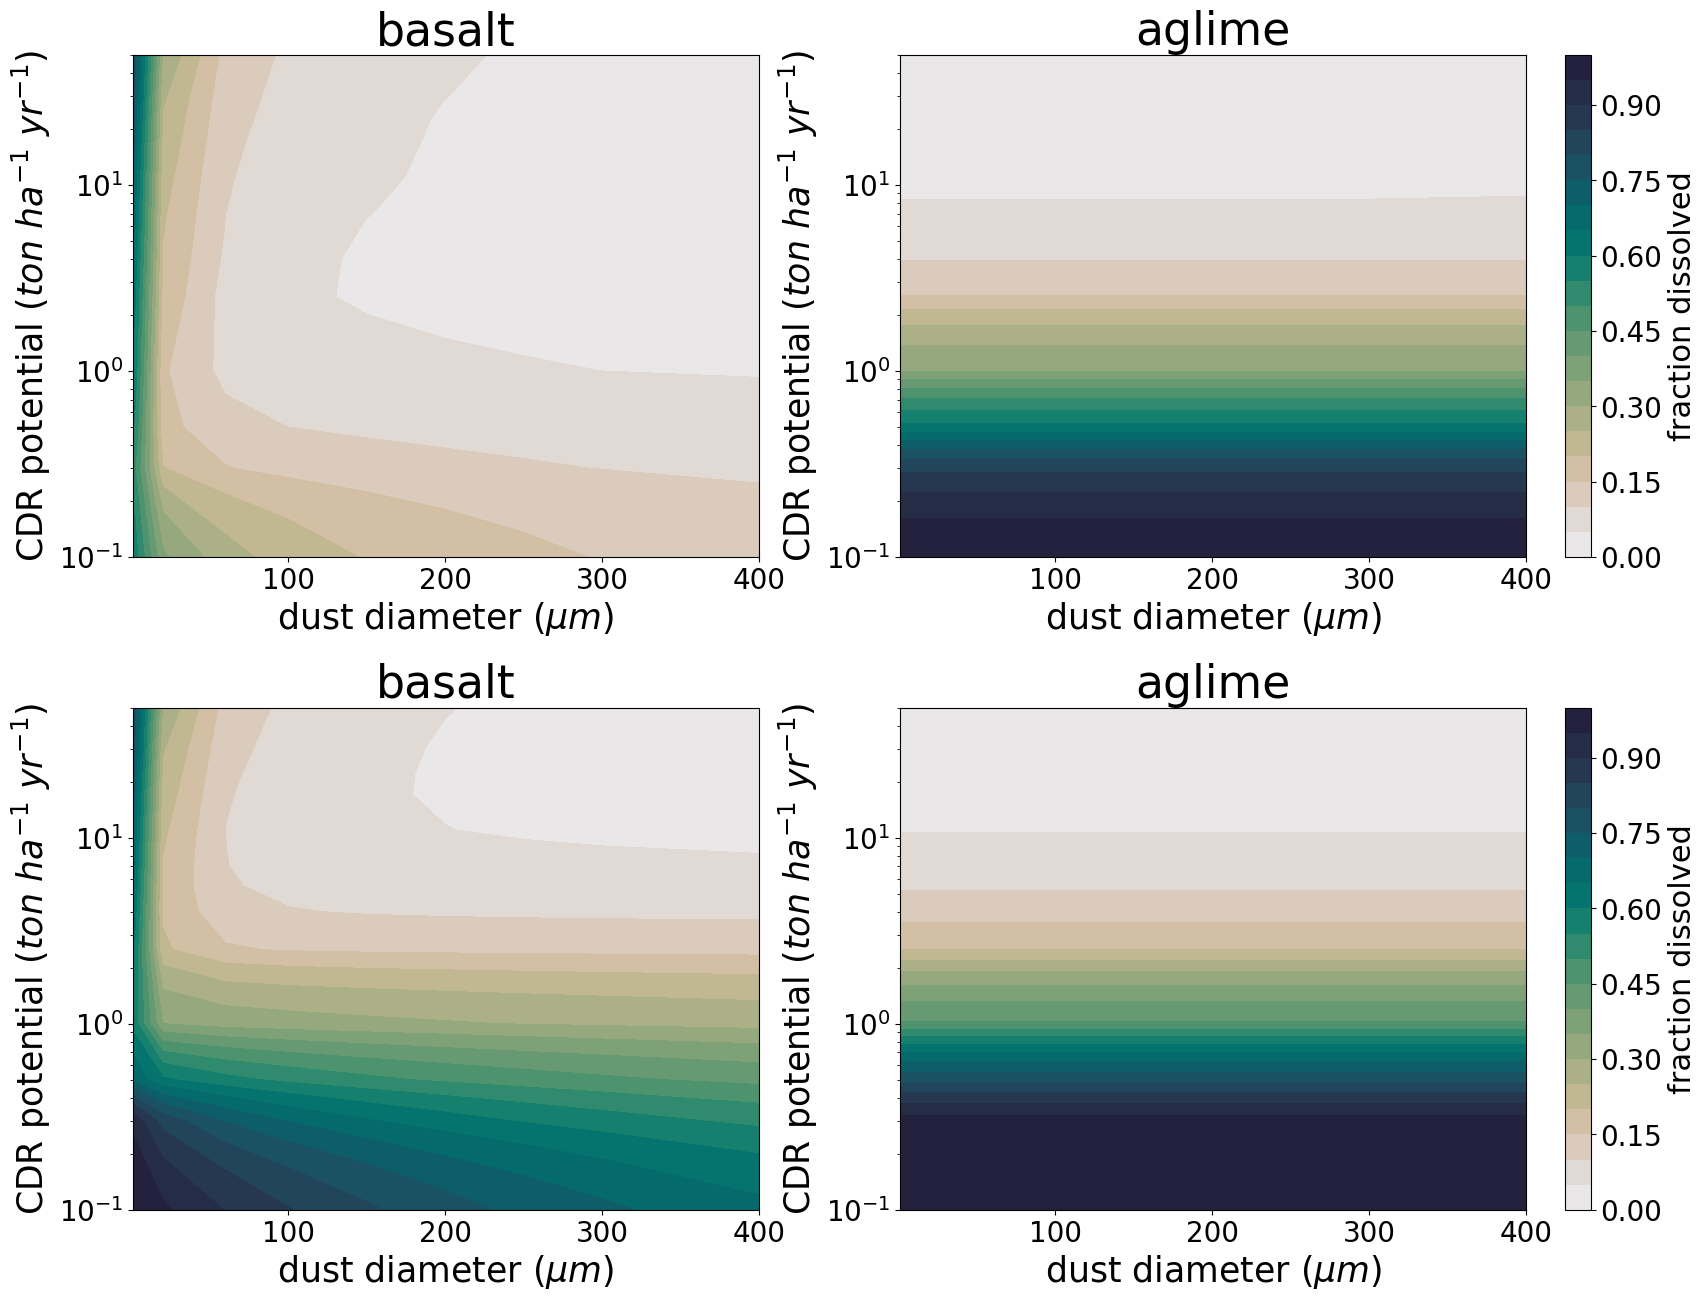

In [12]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'fraction_remaining_dissolved'
loss_perc = 0
fertlevel_show = 12   # [1 | 2 | 12]
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.rain
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0, 1.0
cbar_extend = None    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = np.round(dssil1_p3['cdrpot'].values, 3) # round to avoid floating point errors
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = np.round(dscc1_p3['cdrpot'].values, 3) # round to avoid floating point errors
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = np.round(dssil2_p3['cdrpot'].values, 3) # round to avoid floating point errors
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = np.round(dscc2_p3['cdrpot'].values, 3) # round to avoid floating point errors

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"fraction dissolved", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

## Plot X: individual R 


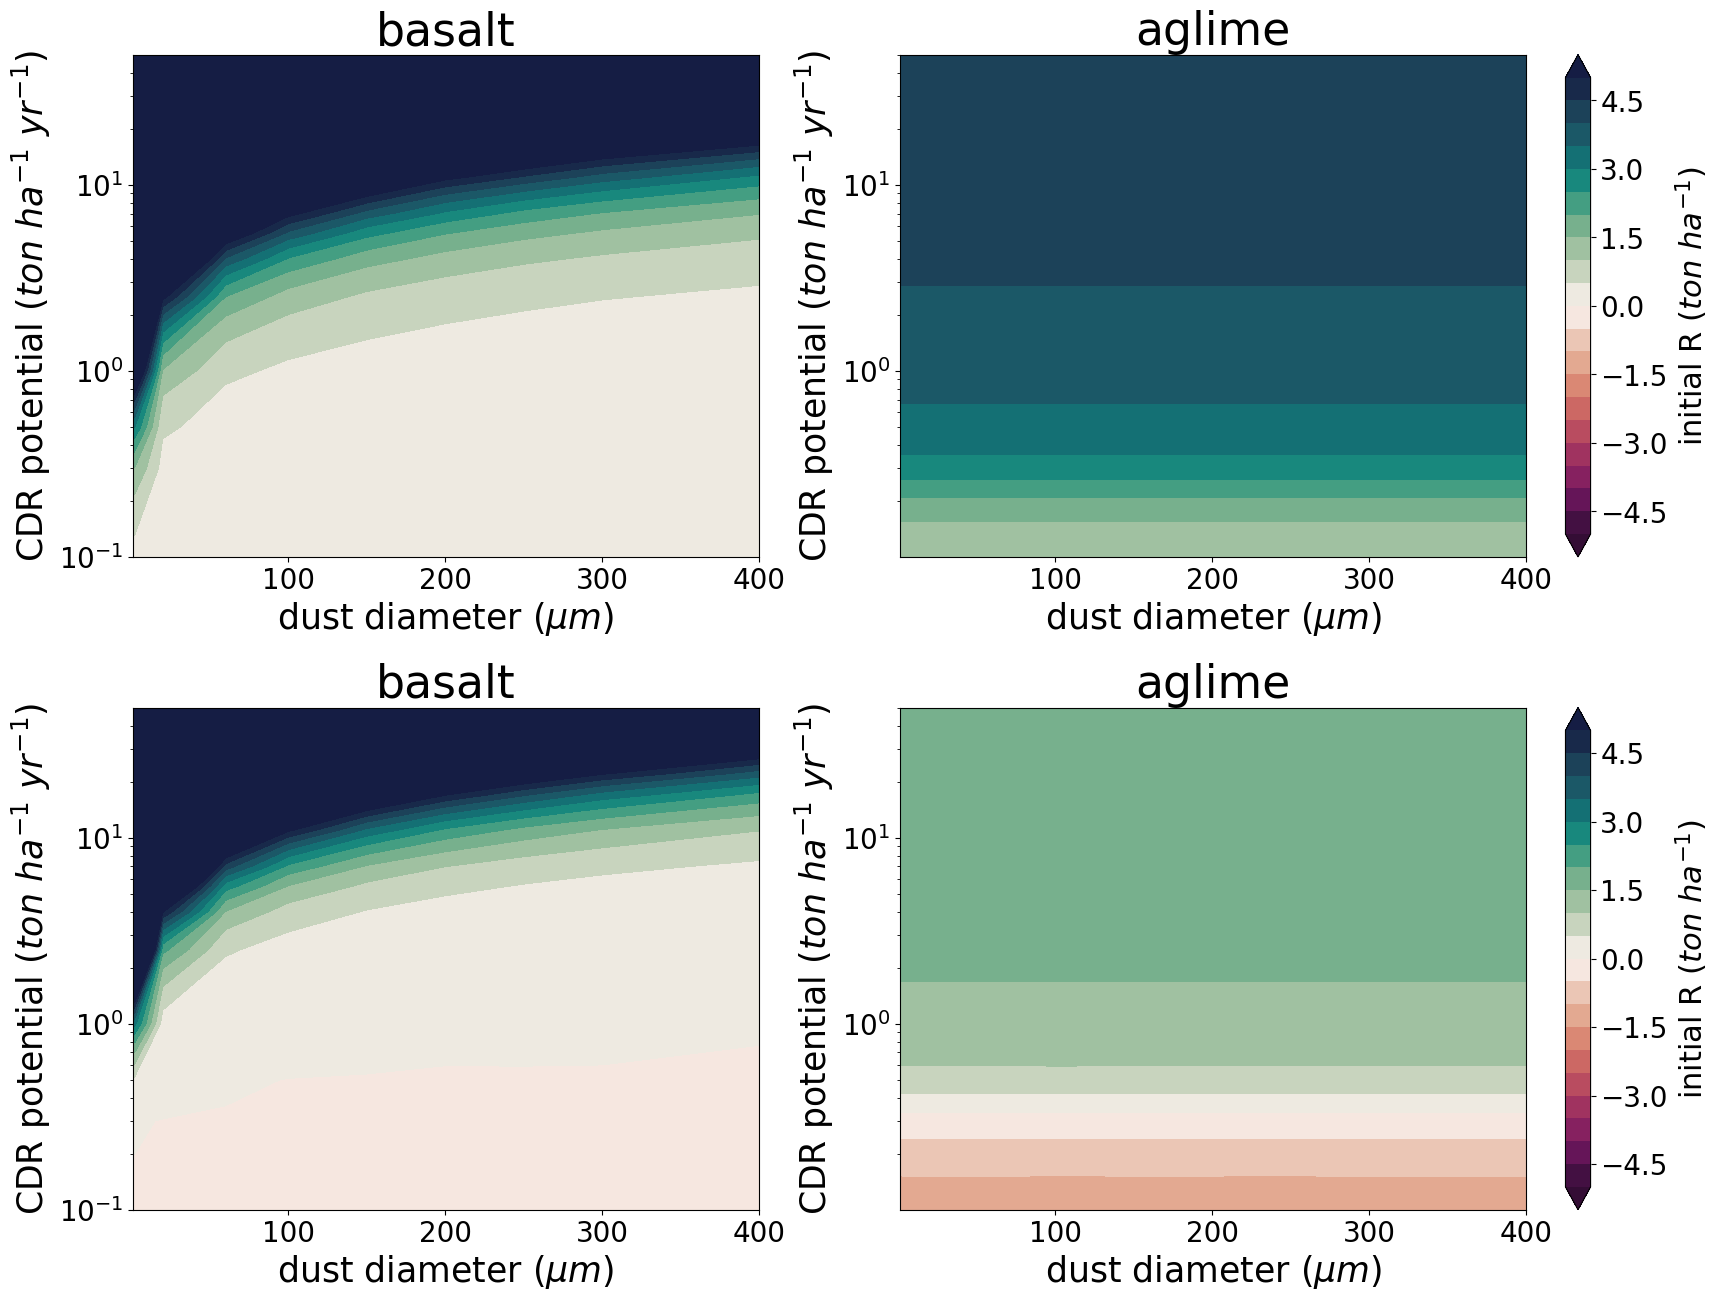

In [19]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12]
logX = False
logY = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['cdrpot'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['cdrpot'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['cdrpot'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['cdrpot'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"CDR potential $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)

## Compare results from matching potential-CDR export fluxes
- following the analysis we shared w/ Frontier team from the `plot_batch_postproc2.ipynb` script

In [20]:
def find_matching_cdr_all(dssil, dscc, cation_dat, cdrvar, loss_percent, tolerance=0.1):
    dssil = dssil.sel(loss_percent = loss_percent, method='nearest').copy()
    dscc = dscc.sel(loss_percent = loss_percent, method='nearest').copy()
    # flatten data
    advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrsil = dssil[cdrvar].values.flatten()
    advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrcc = dscc[cdrvar].values.flatten()
    # flatten coords
    dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='xy')
    dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='xy')
    dratesil = dratesil.flatten()
    dradsil = dradsil.flatten()
    dratecc = dratecc.flatten()
    dradcc = dradcc.flatten()

    # loop through
    results = []
    idxsil = 0
    for asil, csil in zip(advsil, cdrsil):
        # Find matching indices in the second dataset
        mask = (advcc >= asil * (1 - tolerance)) & (advcc <= asil * (1 + tolerance))
        if np.any(mask):
            # matching_adv = advcc[mask]
            # matching_cdr = cdrcc[mask]
            for j in np.where(mask)[0]:
                results.append({
                    'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': advcc[j], 'cdr_cc': cdrcc[j],
                    'dustrate_sil': dratesil[idxsil], 'dustrad_sil': dradsil[idxsil], 
                    'dustrate_cc': dratecc[j], 'dustrad_cc': dradcc[j]
                })
            # for acc, ccc in zip(matching_adv, matching_cdr):
            #     results.append({
            #         'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': acc, 'cdr_cc': ccc,
            #         'dustrate_sil': 
            #     })
        else:
            results.append({
                'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': None, 'cdr_cc': None,
                'dustrate_sil': None, 'dustrad_sil': None, 
                'dustrate_cc': None, 'dustrad_cc': None
            })
        idxsil += 1
        
    outdf = pd.DataFrame(results)

    return outdf

def find_matching_cdr_mean(dssil, dscc, cation_dat, cdrvar, loss_percent, tolerance=0.1):
    # in the other fxn, we take dssil_adv and save every single cc pixel within tolerance
    # here, we just take the mean of every pixel within tolerance
    
    dssil = dssil.sel(loss_percent = loss_percent, method='nearest').copy()
    dscc = dscc.sel(loss_percent = loss_percent, method='nearest').copy()
    # flatten data
    advsil = dssil[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrsil = dssil[cdrvar].values.flatten()
    advcc = dscc[f'DICpot_adv_{cation_dat}'].values.flatten()
    cdrcc = dscc[cdrvar].values.flatten()
    # flatten coords
    dratesil, dradsil = np.meshgrid(dssil['dustrate_ton_ha_yr'].values, dssil['dustrad'].values, indexing='xy')
    dratecc, dradcc = np.meshgrid(dscc['dustrate_ton_ha_yr'].values, dscc['dustrad'].values, indexing='xy')
    dratesil = dratesil.flatten()
    dradsil = dradsil.flatten()
    dratecc = dratecc.flatten()
    dradcc = dradcc.flatten()

    # loop through
    results = []
    for asil, csil in zip(advsil, cdrsil):
        # Find matching indices in the second dataset
        mask = (advcc >= asil * (1 - tolerance)) & (advcc <= asil * (1 + tolerance))
        if np.any(mask):
            results.append({
                    'adv_sil': asil, 'cdr_sil': csil, 
                    'adv_cc': np.nanmean(advcc[mask]), 'cdr_cc': np.nanmean(cdrcc[mask]),
                    'dustrate_sil': np.nanmean(dratesil[mask]), 'dustrad_sil': np.nanmean(dradsil[mask]), 
                    'dustrate_cc': np.nanmean(dratecc[mask]), 'drad_cc': np.nanmean(dradcc[mask])
                })
        else:
            results.append({
                'adv_sil': asil, 'cdr_sil': csil, 'adv_cc': None, 'cdr_cc': None,
                'dustrate_sil': None, 'dustrad_sil': None, 
                'dustrate_cc': None, 'drad_cc': None
            })
        
    outdf = pd.DataFrame(results)

    return outdf


In [51]:
# --- decide the cation data to use
cation_dat = "totcat"    # ["totcat" | "camg"]
# --- decide the CDR variable to use
cdrvar = "cdr_adv" 
# --- select the loss percent
loss_percent = 10
# --- set tolerance
tol = 0.02

df1 = find_matching_cdr_all(dssil1, dscc1, cation_dat, cdrvar, loss_percent, tolerance=tol)
df1['Rcc_Rsil'] = df1['cdr_cc'] / df1['cdr_sil']
# df2 = find_matching_cdr_all(dssil2, dscc2, cation_dat, cdrvar, loss_percent, tolerance=tol)
# df2['Rcc_Rsil'] = df2['cdr_cc'] / df2['cdr_sil']

In [ ]:
# ----